In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [28]:
# 1. Load the dataset
url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv"
data = pd.read_csv(url)

In [29]:
# 2. Advanced Feature Engineering
# Add new features: rooms per household, bedrooms per room, and population per household
data["rooms_per_household"] = data["total_rooms"] / data["households"]
data["bedrooms_per_room"] = data["total_bedrooms"] / data["total_rooms"]
data["population_per_household"] = data["population"] / data["households"]

In [41]:
# 3. Handle missing values and categorical data
numeric_features = data.select_dtypes(include=[np.number]).columns.drop("median_house_value")

In [43]:
# Preprocessing pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing values with median
    ('scaler', StandardScaler())  # Standardize numeric features
])


In [44]:
# Preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with most frequent category
    ('onehot', OneHotEncoder(drop='first'))  # One-Hot Encoding
])

In [45]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [46]:
# 4. Split the data into features (X) and target (y)
X = data.drop("median_house_value", axis=1)
y = data["median_house_value"]


In [47]:
# 5. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# 6. Create a pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))  # Using Gradient Boosting for better performance
])

In [49]:
# 7. Hyperparameter tuning using GridSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__max_depth': [3, 5]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household', 'bedrooms_per_...
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['ocean_proximity'])])),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.01, 0.1],
                         'regressor__max_depth': [3, 5],
                         'regressor__n_estimators': [100, 200]},
             scoring='neg_mean_absolute_error')

In [50]:
# Best model after hyperparameter tuning
best_model = grid_search.best_estimator_

In [51]:
# 8. Evaluate the best model
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Best Model Mean Absolute Error: {mae}")
print(f"Best Model R^2 Score: {r2}")

Best Model Mean Absolute Error: 30528.50190542141
Best Model R^2 Score: 0.8334192884016038


In [52]:
# 9. Cross-validation for robust evaluation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-Validation MAE: {-cv_scores.mean()}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_response.py", line 242, in _get_response_values
    y_pred, pos_label = prediction_method(X), None
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 785, in predict
    Xt = transform.transform(Xt)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_set_output.py", line 3

Cross-Validation MAE: nan


In [53]:
# 10. Feature Importance
feature_importances = best_model.named_steps['regressor'].feature_importances_
feature_names = numeric_features.tolist() + list(best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

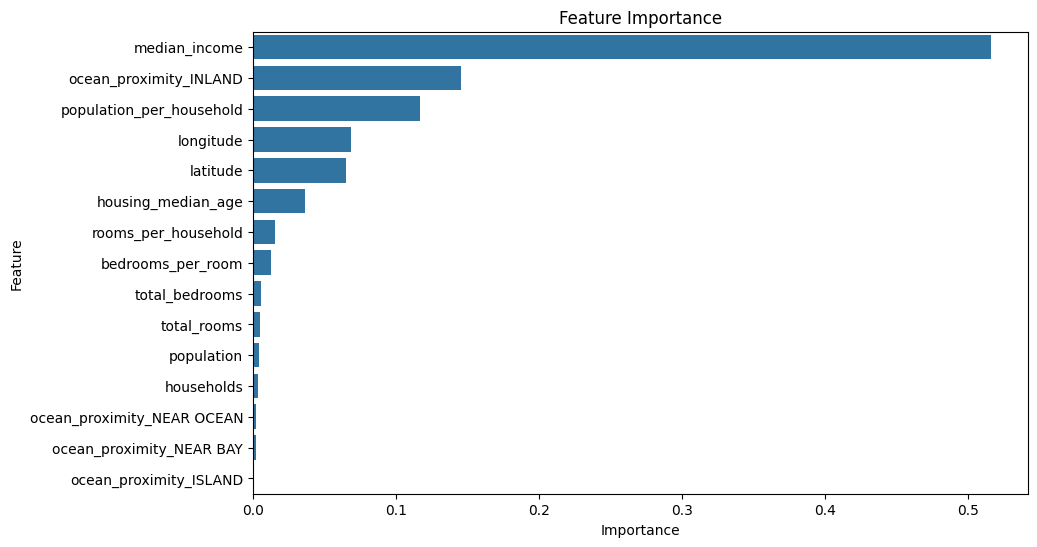

In [54]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [55]:
# 11. Save the model for deployment
joblib.dump(best_model, 'housing_price_predictor.pkl')

['housing_price_predictor.pkl']

In [56]:
# 12. Load the model (example)
loaded_model = joblib.load('housing_price_predictor.pkl')